In [7]:
import numpy as np 
import matplotlib.pyplot as plt
from qutip import *

<h2>
    <center>
        General Ramsey Spectroscopy
    </center>
</h2>

Suppose that we have a pulse with turn-on time much faster than the time scale of the system. According to [Wikipedia](https://en.wikipedia.org/wiki/Bloch_sphere) a rotation about the $y$-axis of the Bloch sphere can be written as

$$
R_x(\theta) = \cos(\theta/2) \mathbb{I} - i \sin(\theta/2) \sigma_x
$$

where $\theta$ is the rotation angle of the qubit state, $\mathbb{I}$ is the identity operator, and $\sigma_x = \sigma + \sigma^\dagger$. 

In [17]:
class N_dipole_system:
    def __init__(self, N):
        # Number of atoms 
        self.N = N

        ### annihilation operators ###
        idatom = qeye(2)  # identity operator
        sm = projection(2, 0, 1)  # |1><0| for an Ns-state system

        self.sm_list = []
        for i in range(N):
            op_list = [idatom] * N
            op_list[i] = sm
            self.sm_list.append(tensor(op_list))

        
        ### initial states ###
        self.ket_excited = ket( [1]*N, dim = [2] * N)
        self.ket_ground = ket( [0]*N, dim = [2] * N)

        # total spin operators
        self.id_tot = tensor([qeye(2)] * N)
        self.sm_tot = self.ket_ground * self.ket_excited.dag()
        self.sp_tot = self.sm_tot.dag()
        self.sz_tot = self.sp_tot * self.sm_tot - self.sm_tot * self.sp_tot
        self.sx_tot = self.sp_tot + self.sm_tot

    
    def Rx(self, theta):
        return np.cos(theta/2)*self.id_tot - 1j*np.sin(theta/2)*self.sx_tot

<h2>
    <center>
        Two non-interacting atoms with different frequencies
    </center>
</h2>

Suppose that we have two non-interacting atoms with different frequencies. The Hamiltonian of the system is

$$
H = \frac{\hbar \omega_1}{2} \sigma_1^\dagger \sigma_1 + \frac{\hbar \omega_2}{2} \sigma_2^\dagger \sigma_2
$$

where $\omega_1$ and $\omega_2$ are the frequencies of the two atoms. For simplicity, we assume that the decay time is much longer than the time scale of the experiment. 

Text(0, 0.5, '$\\rho_{ee}$')

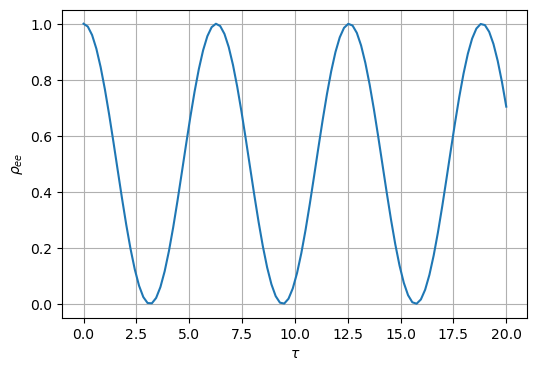

In [43]:
sys = N_dipole_system(2)

omega_0 = 0
omega_1 = 1
H = omega_0 * sys.sm_list[0].dag() * sys.sm_list[0] + omega_1 * sys.sm_list[1].dag() * sys.sm_list[1]

tlist = np.linspace(0, 20, 100)

psi0 = sys.ket_ground
psi0 = sys.Rx(np.pi/2) * psi0
res = mesolve(H, psi0, tlist, c_ops=[])
states = res.states
states = [sys.Rx(np.pi/2) * state for state in states]

excited_state_pop = [expect(sys.sm_tot.dag() * sys.sm_tot, state) for state in states]

plt.figure(figsize=(6,4))
plt.plot(tlist, excited_state_pop)
plt.grid(True)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\rho_{ee}$')

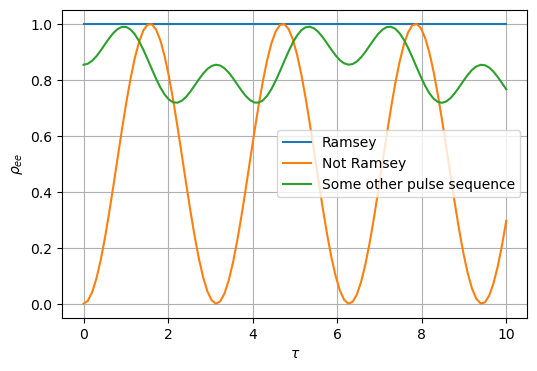

In [56]:
sys = N_dipole_system(2)

omega_0 = 0
omega_1 = 1
H = omega_0 * sys.sm_list[0].dag() * sys.sm_list[0] + omega_1 * sys.sm_list[1].dag() * sys.sm_list[1]

tlist = np.linspace(0, 10, 100)

def pulse_sequence(t, theta_list):
    psi = sys.ket_ground
    for n, theta in enumerate(theta_list):
        psi = sys.Rx(theta) * psi
        if n != len(theta_list) - 1:
            psi = mesolve(H, psi, [0,t], c_ops=[]).states[-1]
    return expect(sys.sp_tot.dag() * sys.sp_tot, psi)


rho_e_ramsey = [pulse_sequence(t, [np.pi/2, np.pi, np.pi/2]) for t in tlist]
rho_e_not_ramsey = [pulse_sequence(t, [np.pi/2, 0, np.pi/2]) for t in tlist]
rho_e_whatever = [pulse_sequence(t, [np.pi/2, np.pi/2, np.pi/2, np.pi/4]) for t in tlist]


plt.figure(figsize=(6,4))
plt.plot(tlist, rho_e_ramsey, label='Ramsey')
plt.plot(tlist, rho_e_not_ramsey, label='Not Ramsey')
plt.plot(tlist, rho_e_whatever, label='Some other pulse sequence')
plt.grid(True)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\rho_{ee}$')
plt.legend()